## Results of Host Prediction
### Dataset: All viruses, all proteins, without duplicates (~19K)

**Models**: Logistic Regression, Random Forest, FNN, RNN, LSTM, TF

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1114

**Classification**: Multi-class

**\# classes**: 10

**\# train samples** = 14,633

**\# test samples** = 3,659

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve

In [16]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"

def compute_auprc(df_itr, y_pred_columns, y_true_col):
    pr_curves = []
    auprcs = []
    for y_pred_column in y_pred_columns:
        precision, recall, _ = precision_recall_curve(y_true=df_itr[y_true_col].values, probas_pred=df_itr[y_pred_column].values, pos_label=y_pred_column)
        pr_curves.append(pd.DataFrame({"precision": precision, "recall": recall, "class": y_pred_column}))
        auprcs.append({"class": y_pred_column, "auprc": auc(recall, precision)})
    return pd.concat(pr_curves, ignore_index=True), pd.DataFrame(auprcs)

def compute_class_distribution(df, label_col, format=False):
    labels_counts = df[label_col].value_counts()
    n = labels_counts.sum()
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k} ({v:.2f}%)" for k, v, in labels_counts.items()}
    return labels_counts
    
def plot_auprc(auprc_df, metadata, model_name):
    # sort by median
    sorted_median_auprc_df = auprc_df.groupby("class")["auprc"].median().sort_values(ascending=False)
    
    plt.clf()
    sns.set_theme()

    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['figure.autolayout'] = True
    plt.figure(figsize=(10, 10))
    ax = sns.boxplot(data=auprc_df, x="class", y="auprc", order=sorted_median_auprc_df.index)
    ax.set_ylim(0, 1)
    ax.set_xticklabels([metadata[t.get_text()] for t in ax.get_xticklabels()])
    ax.set_title(f"Model = {model_name}")
    plt.tight_layout()
    plt.xticks(rotation=-90)
    plt.show()
    
def plot_pr_curves(pr_curves_df, metadata, model_name):
    plt.clf()
    sns.set_theme()
    hue_order = None
    if metadata is not None:
        pr_curves_df_metadata = pr_curves_df.replace({"class": metadata})
        hue_order = list(metadata.values())
    plt.figure(figsize=(12,8))
    ax = sns.lineplot(data=pr_curves_df_metadata, x="recall", y="precision", hue="class", hue_order=hue_order, ci=None)
    ax.set_title(f"Model = {model_name}")
    ax.set_ylim(0, 1)
    plt.rcParams['xtick.labelsize'] = 8
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    plt.show()
    
def auprc_analysis(output_filepath, model_name):
    df = pd.read_csv(output_filepath, index_col=0)
    print(f"Read output size = {df.shape}")
    cols = df.columns
    non_human_cols = list(set(cols) - set([itr_col, experiment_col, y_true_col, human_col]))
    print(f"NonHuman cols = {non_human_cols}")
    
    itrs = df[itr_col].unique()
    print(f"Itrs = {itrs}")
    
    auprc = []
    pr_curves = []
    for itr in itrs:
        df_itr = df[df[itr_col] == itr]
        pr_curves_df, auprcs_df = compute_auprc(df_itr, y_pred_columns=non_human_cols + [human_col], y_true_col=y_true_col)
        pr_curves_df[itr_col] = itr
        auprcs_df[itr_col] = itr
        auprc.append(auprcs_df)
        pr_curves.append(pr_curves_df)

    auprc_df = pd.concat(auprc, ignore_index=True)
    pr_curves_df = pd.concat(pr_curves, ignore_index=True)
    
    metadata = compute_class_distribution(df_itr, y_true_col, format=True)
    
    # Remove Others class
    metadata.pop("Others")
    auprc_df = auprc_df.loc[auprc_df["class"] != "Others"]
    
    plot_auprc(auprc_df, metadata, model_name)
    plot_pr_curves(pr_curves_df, metadata, model_name)
    

def auprc_analysis_classes_subset(output_filepaths, classes):
    macro_auprcs = []
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        itrs = df[itr_col].unique()
        print(f"Itrs = {itrs}")
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = compute_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            macro_auprcs.append({"model": model,
                                 "itr": itr,
                                 "auprc": auprcs_df["auprc"].mean()})
    macro_auprcs_df = pd.DataFrame(macro_auprcs)

    plt.clf()
    sns.set_theme()

    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['figure.autolayout'] = True
    plt.figure(figsize=(10, 10))
    ax = sns.boxplot(data=macro_auprcs_df, x="model", y="auprc")
    ax.set_ylim(0, 1)
    ax.set_title(f"Macro AUPRC [Classes = {classes}]")
    plt.tight_layout()
    plt.show()
    

### Logistic Regression

Read output size = (18295, 11)
NonHuman cols = ['Goat', 'Wood mouse', 'Red junglefowl', 'Desert warthog', 'Lesser bandicoot rat', 'Horse', 'Cattle', 'Others']
Itrs = [0 1 2 3 4]


<Figure size 640x480 with 0 Axes>

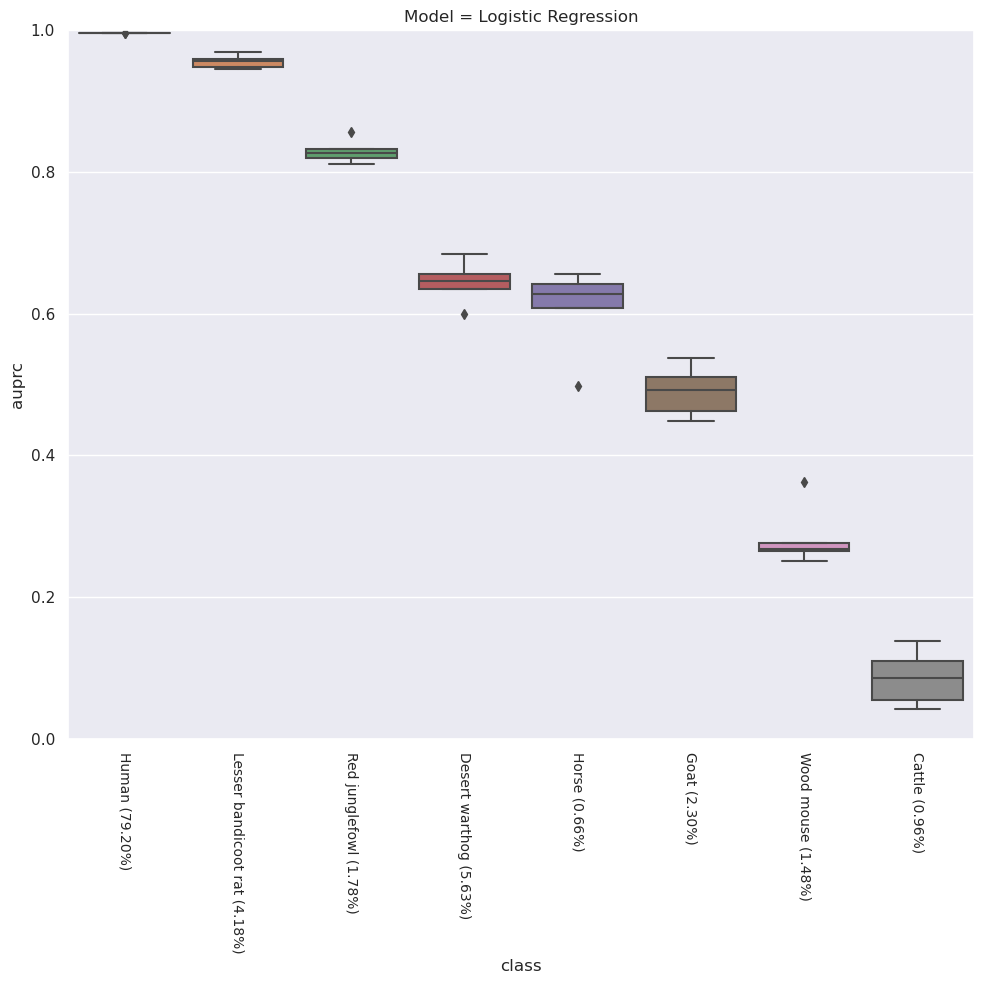

/tmp/ipykernel_20128/975036094.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=pr_curves_df_metadata, x="recall", y="precision", hue="class", hue_order=hue_order, ci=None)


<Figure size 640x480 with 0 Axes>

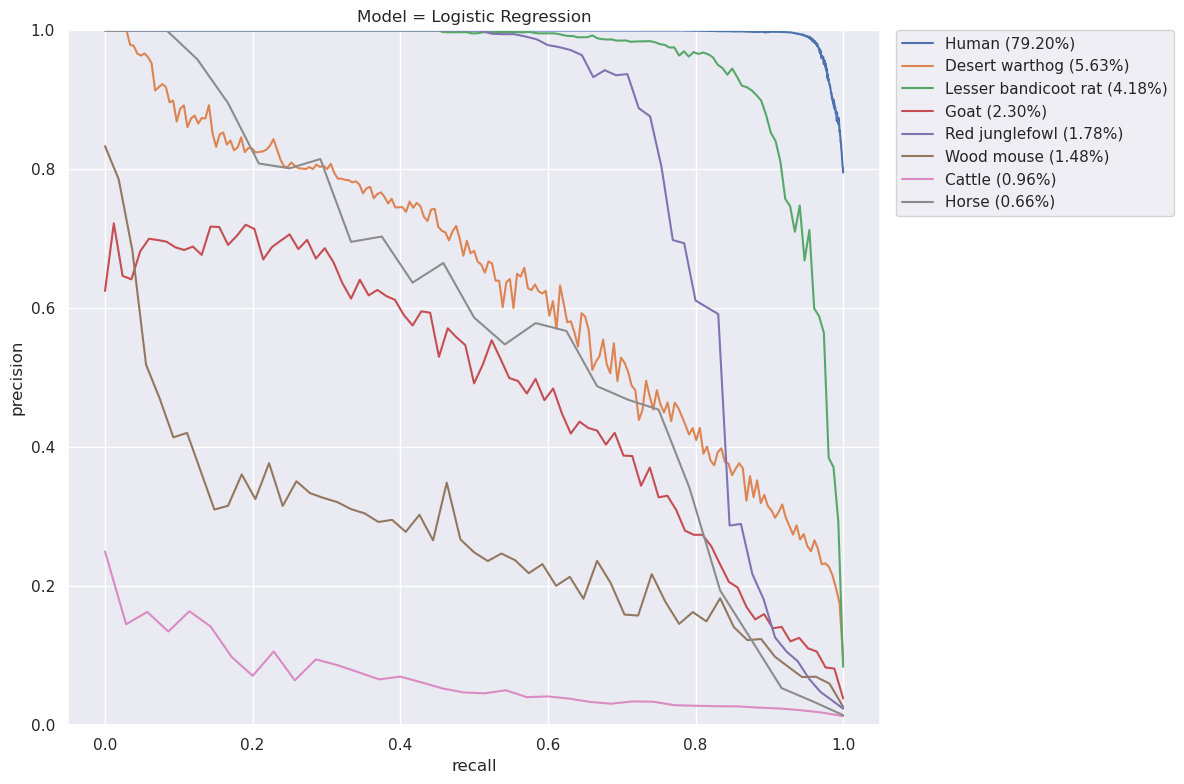

In [3]:
lr_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230705/host_multi_msl1114_baseline/kmer_k3_virus_host_name_multi_kmer_k3-loss_ce__lr_output.csv")
auprc_analysis(lr_output_filepath, "Logistic Regression")

### Random Forest

Read output size = (18295, 11)
NonHuman cols = ['Goat', 'Wood mouse', 'Red junglefowl', 'Desert warthog', 'Lesser bandicoot rat', 'Horse', 'Cattle', 'Others']
Itrs = [0 1 2 3 4]


<Figure size 640x480 with 0 Axes>

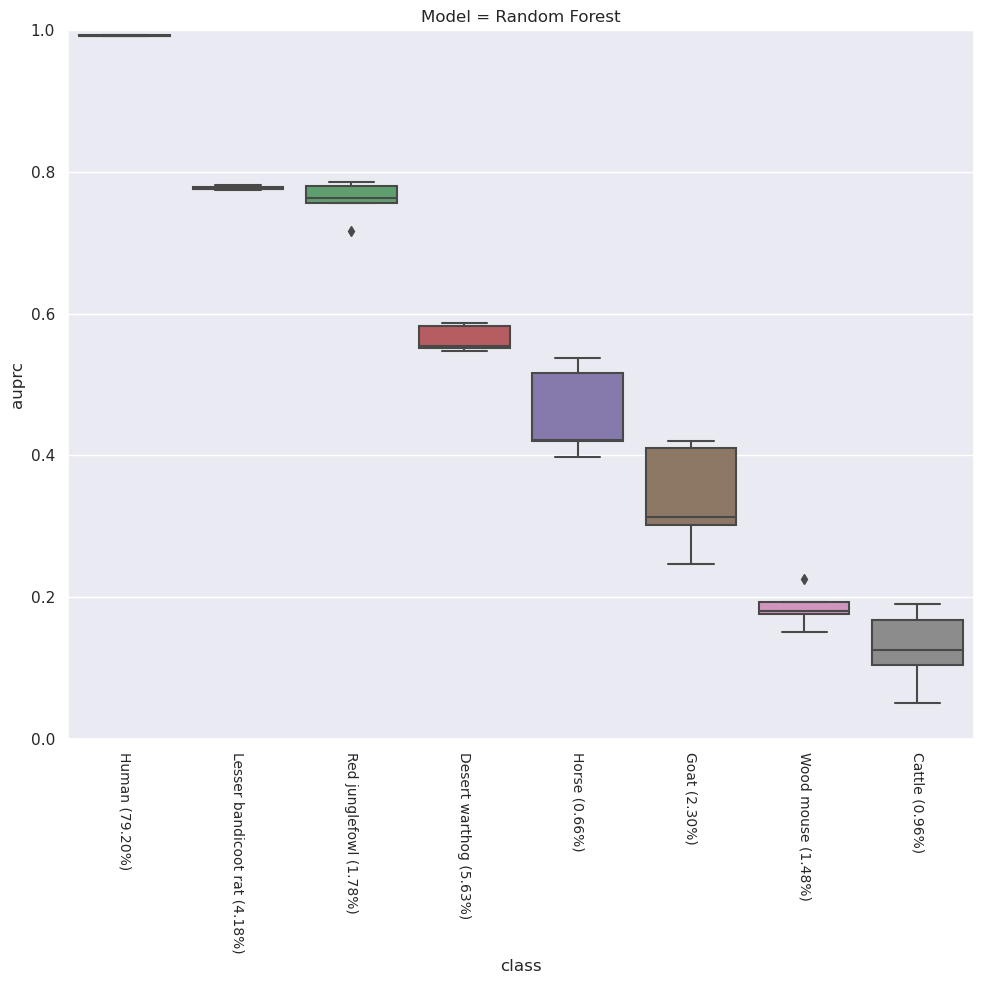

/tmp/ipykernel_20128/975036094.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=pr_curves_df_metadata, x="recall", y="precision", hue="class", hue_order=hue_order, ci=None)


<Figure size 640x480 with 0 Axes>

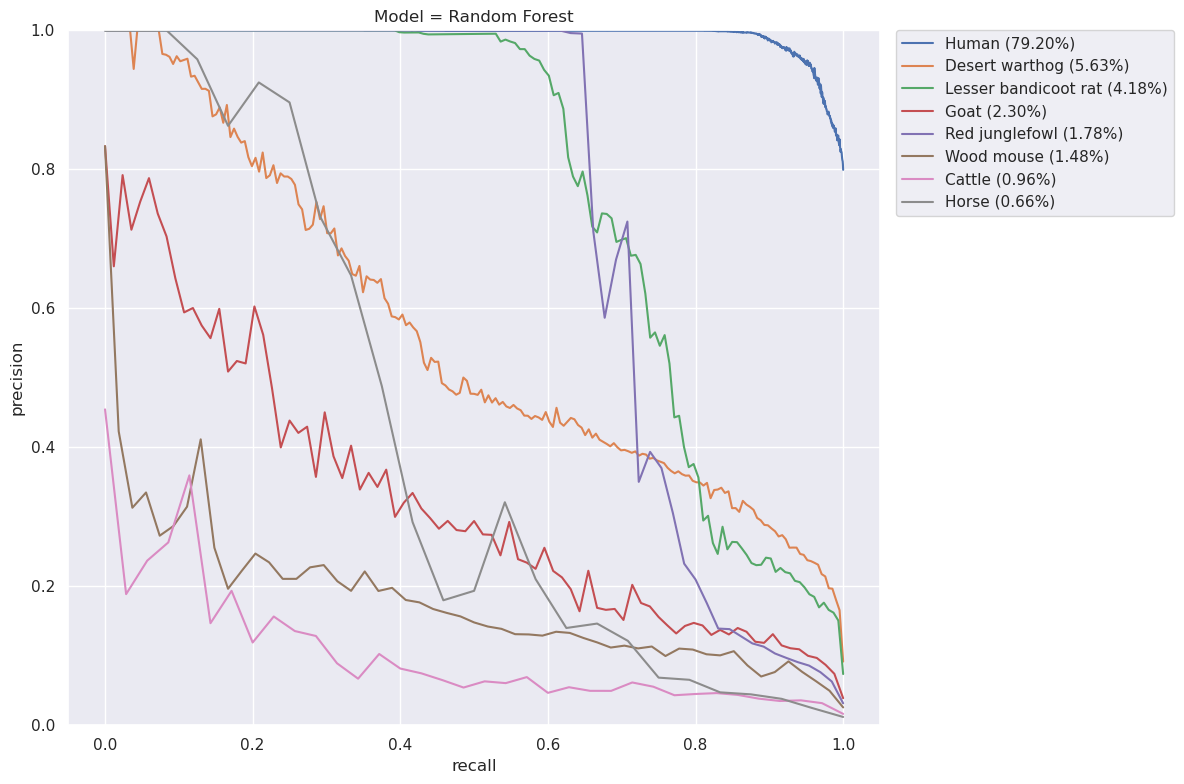

In [4]:
rf_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230705/host_multi_msl1114_baseline/kmer_k3_virus_host_name_multi_kmer_k3-loss_ce__rf_output.csv")
auprc_analysis(rf_output_filepath, "Random Forest")

### FNN

Read output size = (18295, 11)
NonHuman cols = ['Goat', 'Wood mouse', 'Red junglefowl', 'Desert warthog', 'Lesser bandicoot rat', 'Horse', 'Cattle', 'Others']
Itrs = [0 1 2 3 4]


<Figure size 640x480 with 0 Axes>

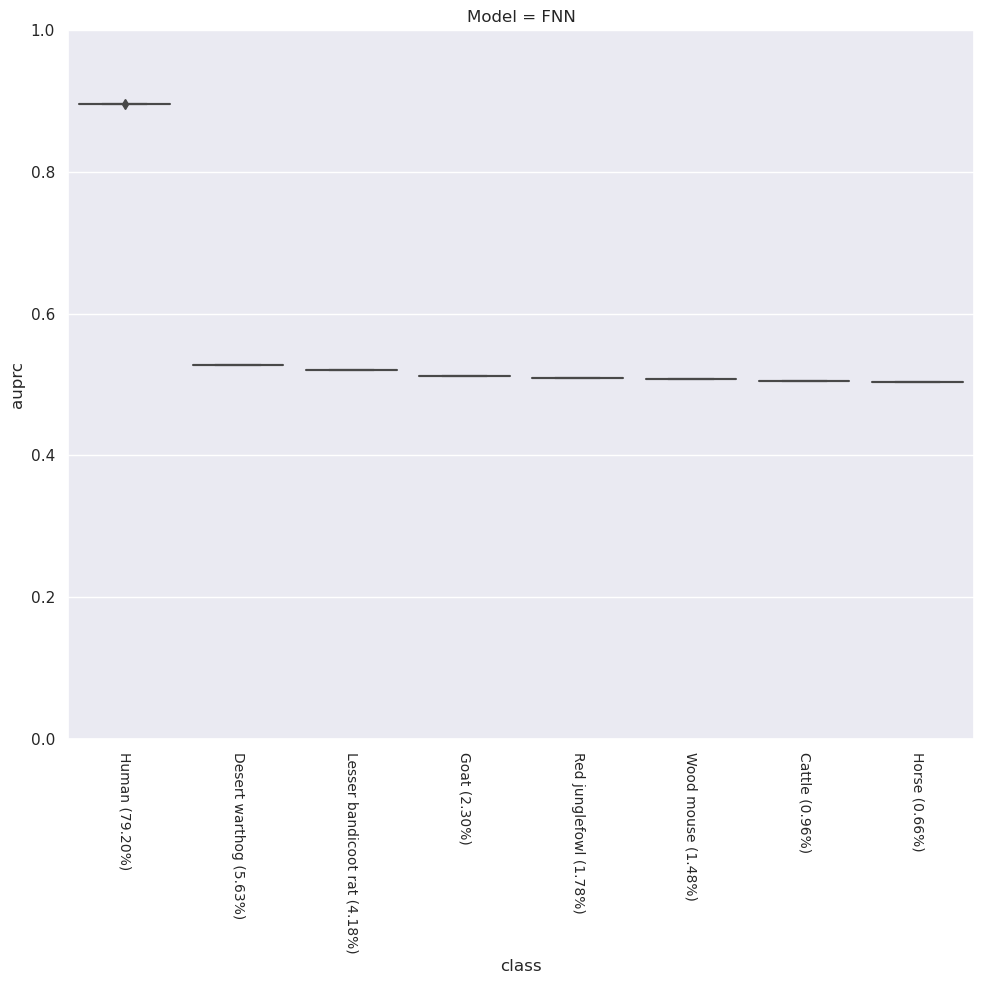

/tmp/ipykernel_20128/975036094.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=pr_curves_df_metadata, x="recall", y="precision", hue="class", hue_order=hue_order, ci=None)


<Figure size 640x480 with 0 Axes>

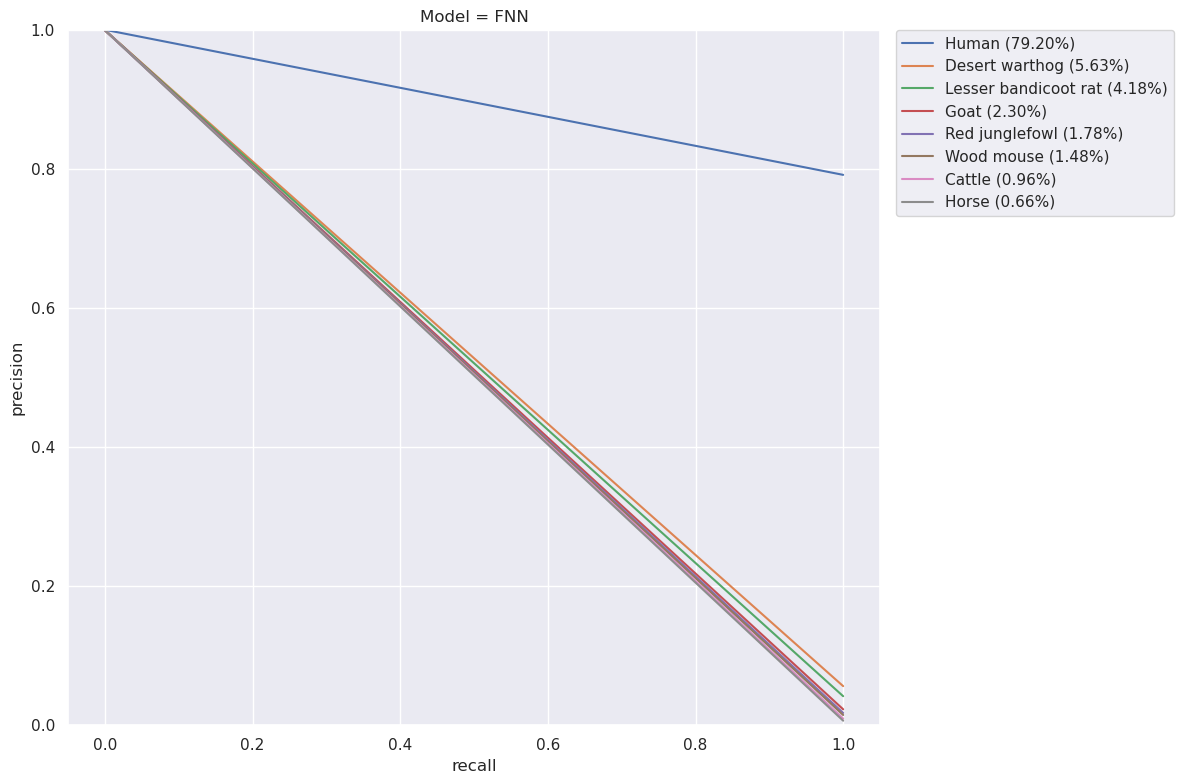

In [5]:
fnn_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230709/host_multi_baseline_focal/emb_sincos-d_1024-loss_focalce_fnn-l_10_output.csv")
auprc_analysis(fnn_output_filepath, "FNN")

### RNN

Read output size = (18295, 11)
NonHuman cols = ['Goat', 'Wood mouse', 'Red junglefowl', 'Desert warthog', 'Lesser bandicoot rat', 'Horse', 'Cattle', 'Others']
Itrs = [0 1 2 3 4]


<Figure size 640x480 with 0 Axes>

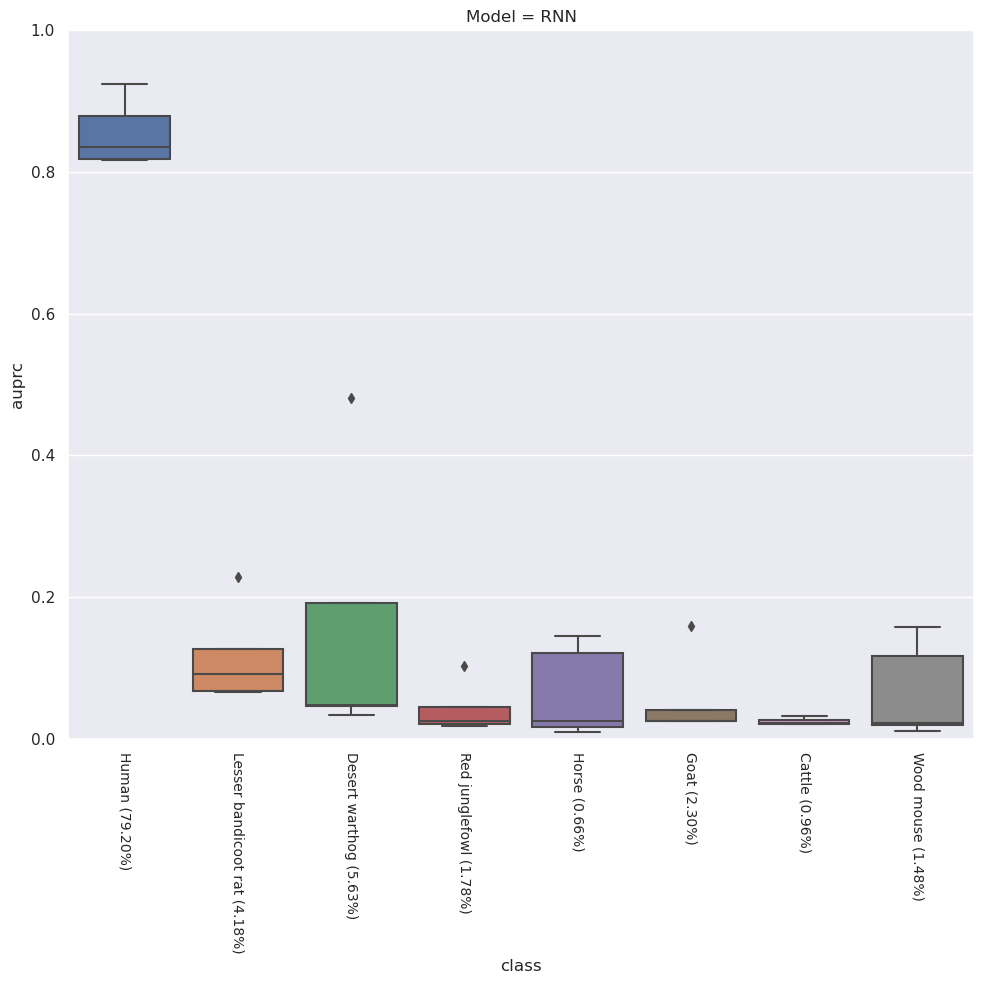

/tmp/ipykernel_20128/975036094.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=pr_curves_df_metadata, x="recall", y="precision", hue="class", hue_order=hue_order, ci=None)


<Figure size 640x480 with 0 Axes>

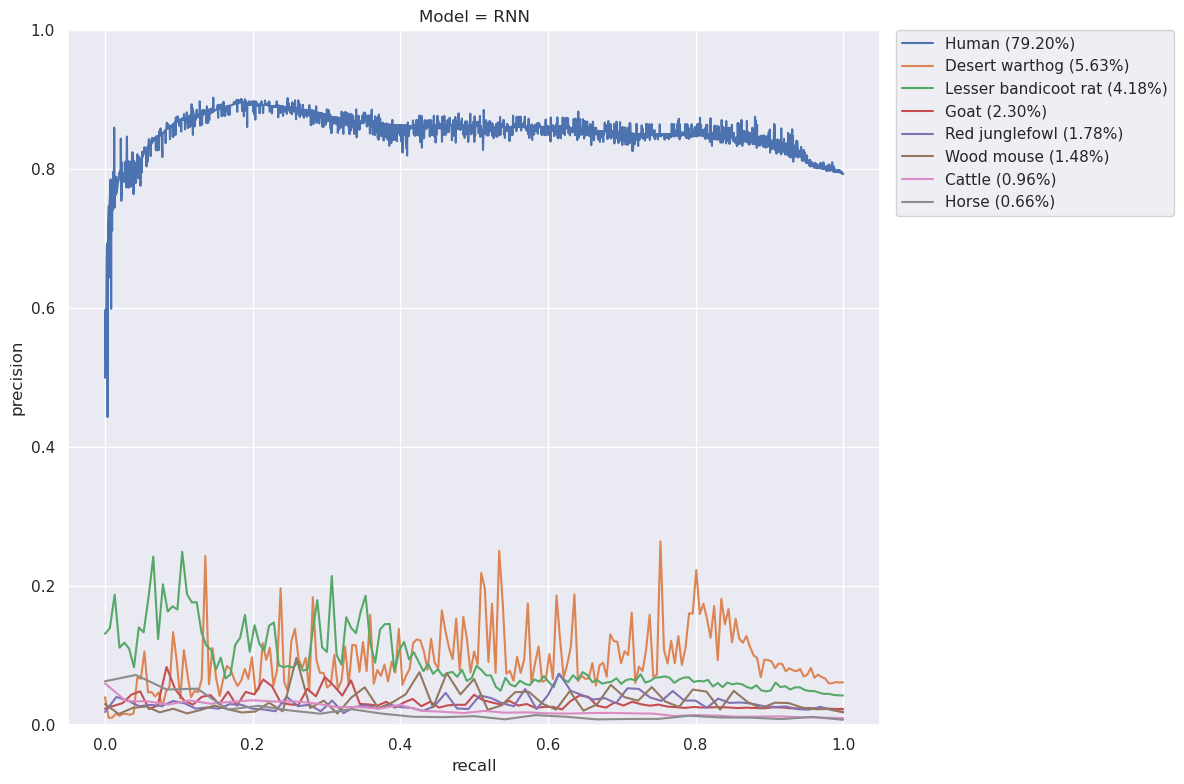

In [6]:
rnn_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230709/host_multi_baseline_focal/emb_sincos-d_1024-loss_focalce_rnn-l_6_output.csv")
auprc_analysis(rnn_output_filepath, "RNN")

### LSTM

Read output size = (18295, 11)
NonHuman cols = ['Goat', 'Wood mouse', 'Red junglefowl', 'Desert warthog', 'Lesser bandicoot rat', 'Horse', 'Cattle', 'Others']
Itrs = [0 1 2 3 4]


<Figure size 640x480 with 0 Axes>

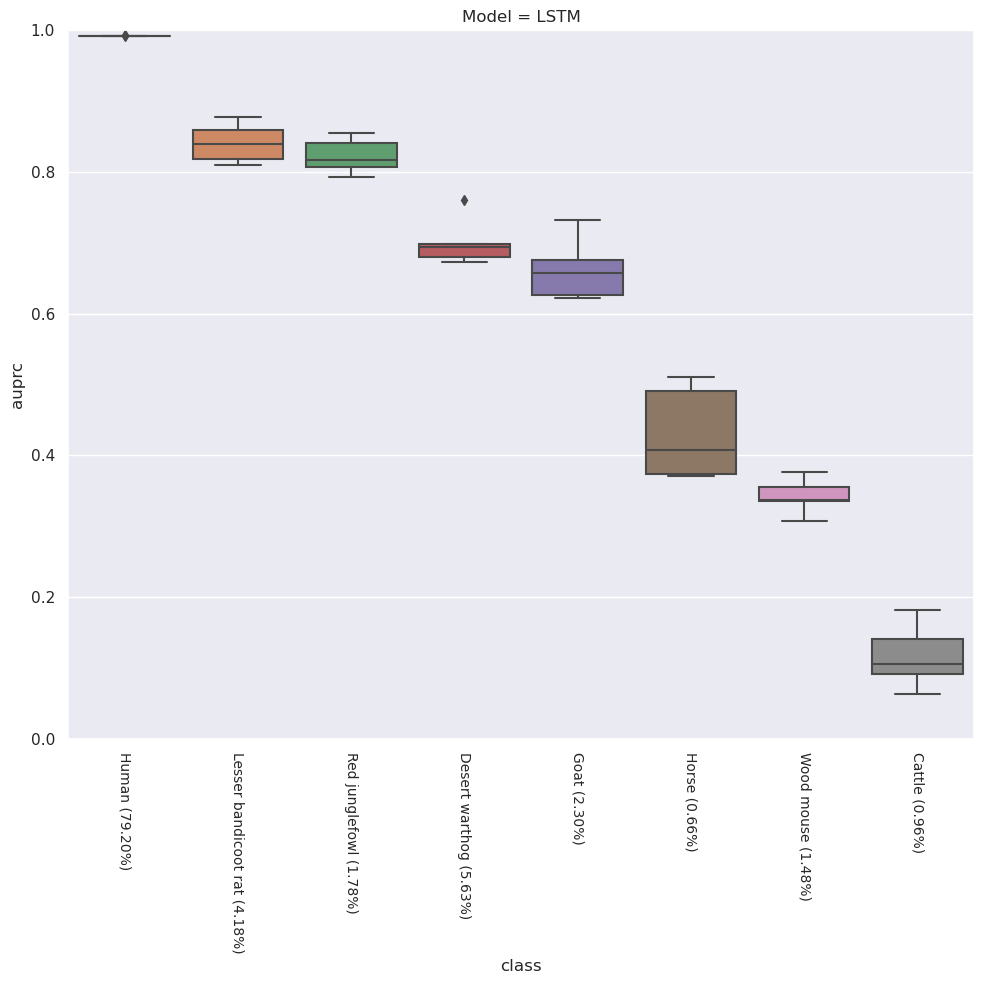

/tmp/ipykernel_20128/975036094.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=pr_curves_df_metadata, x="recall", y="precision", hue="class", hue_order=hue_order, ci=None)


<Figure size 640x480 with 0 Axes>

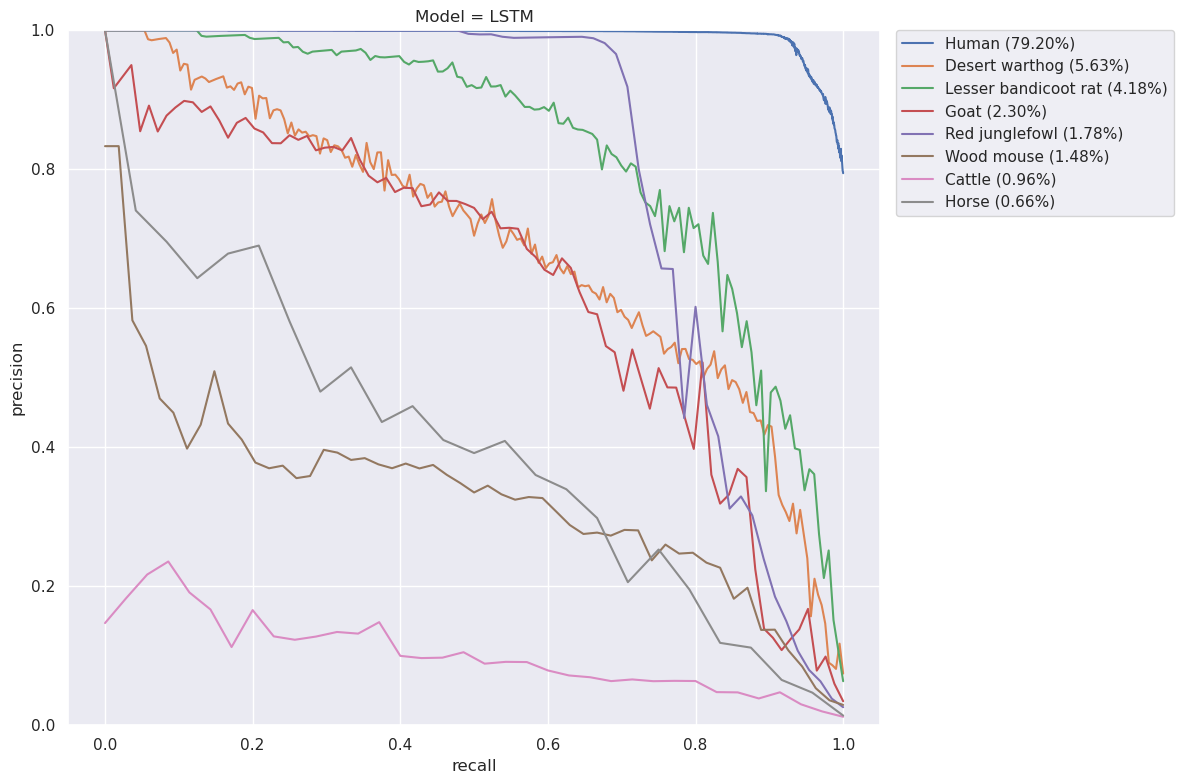

In [7]:
lstm_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230709/host_multi_baseline_focal/emb_sincos-d_1024-loss_focalce_lstm-l_2_output.csv")
auprc_analysis(lstm_output_filepath, "LSTM")

### Transformer

Read output size = (18295, 11)
NonHuman cols = ['Goat', 'Wood mouse', 'Red junglefowl', 'Desert warthog', 'Lesser bandicoot rat', 'Horse', 'Cattle', 'Others']
Itrs = [0 1 2 3 4]


<Figure size 640x480 with 0 Axes>

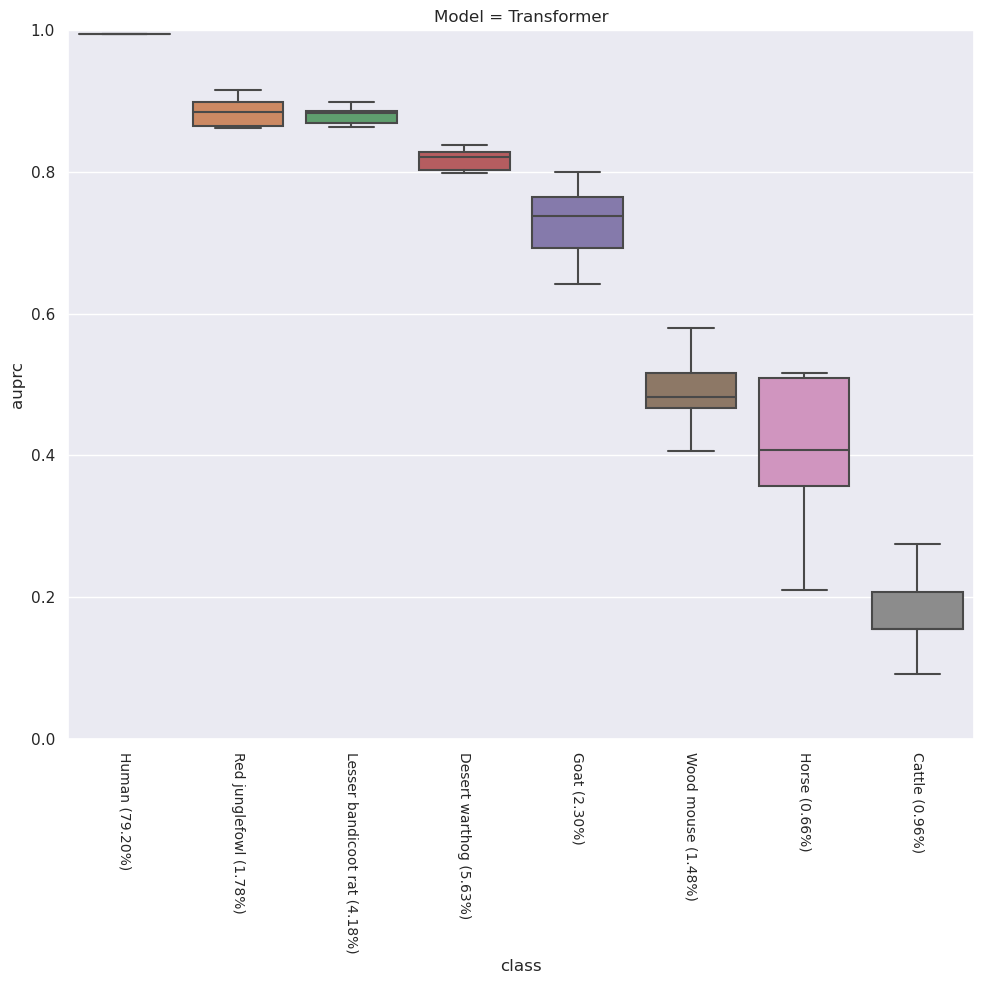

/tmp/ipykernel_20128/975036094.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=pr_curves_df_metadata, x="recall", y="precision", hue="class", hue_order=hue_order, ci=None)


<Figure size 640x480 with 0 Axes>

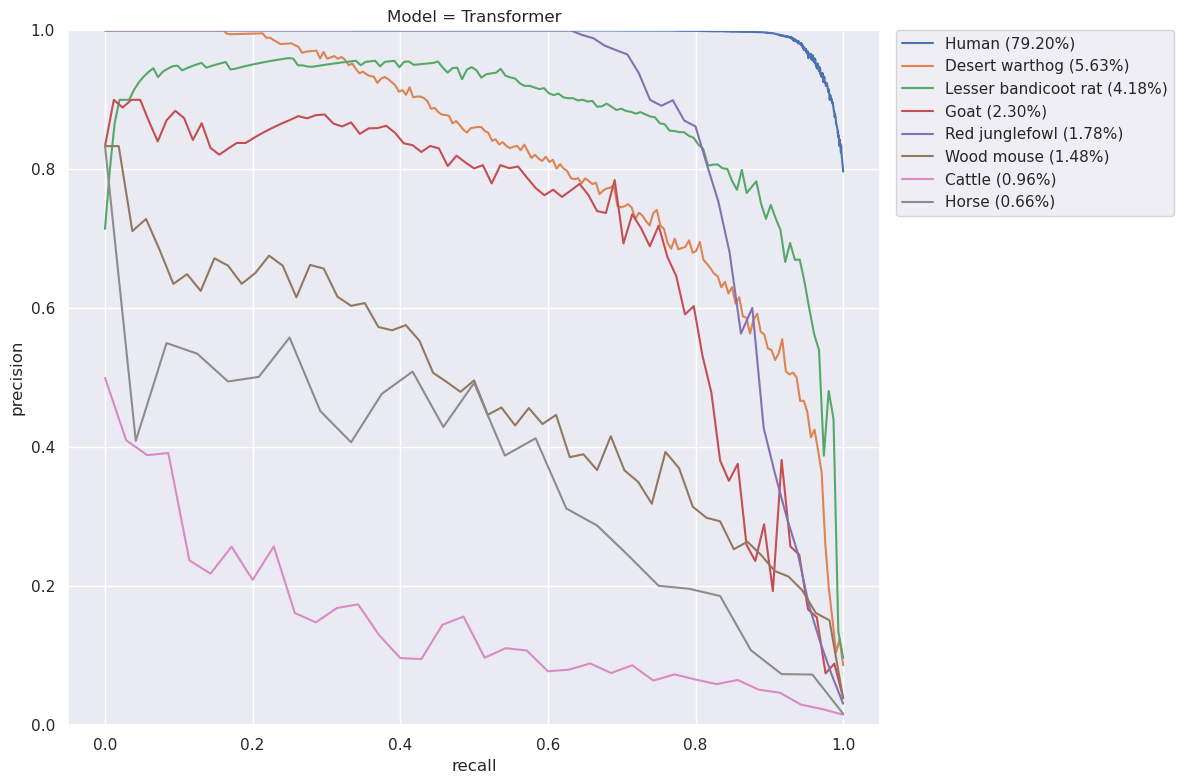

In [8]:
tf_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230709/host_multi_baseline_focal/emb_sincos-d_1024-loss_focalce_transformer-l_6-h_8_output.csv")
auprc_analysis(tf_output_filepath, "Transformer")

### Macro AUPRC of all models with selected hosts classes (top 5 from Transformer)

Read output LR = (18295, 11)
Itrs = [0 1 2 3 4]
Read output RF = (18295, 11)
Itrs = [0 1 2 3 4]
Read output FNN_10l = (18295, 11)
Itrs = [0 1 2 3 4]
Read output RNN_6l = (18295, 11)
Itrs = [0 1 2 3 4]
Read output LSTM_2l = (18295, 11)
Itrs = [0 1 2 3 4]
Read output TF_6l = (18295, 11)
Itrs = [0 1 2 3 4]


<Figure size 640x480 with 0 Axes>

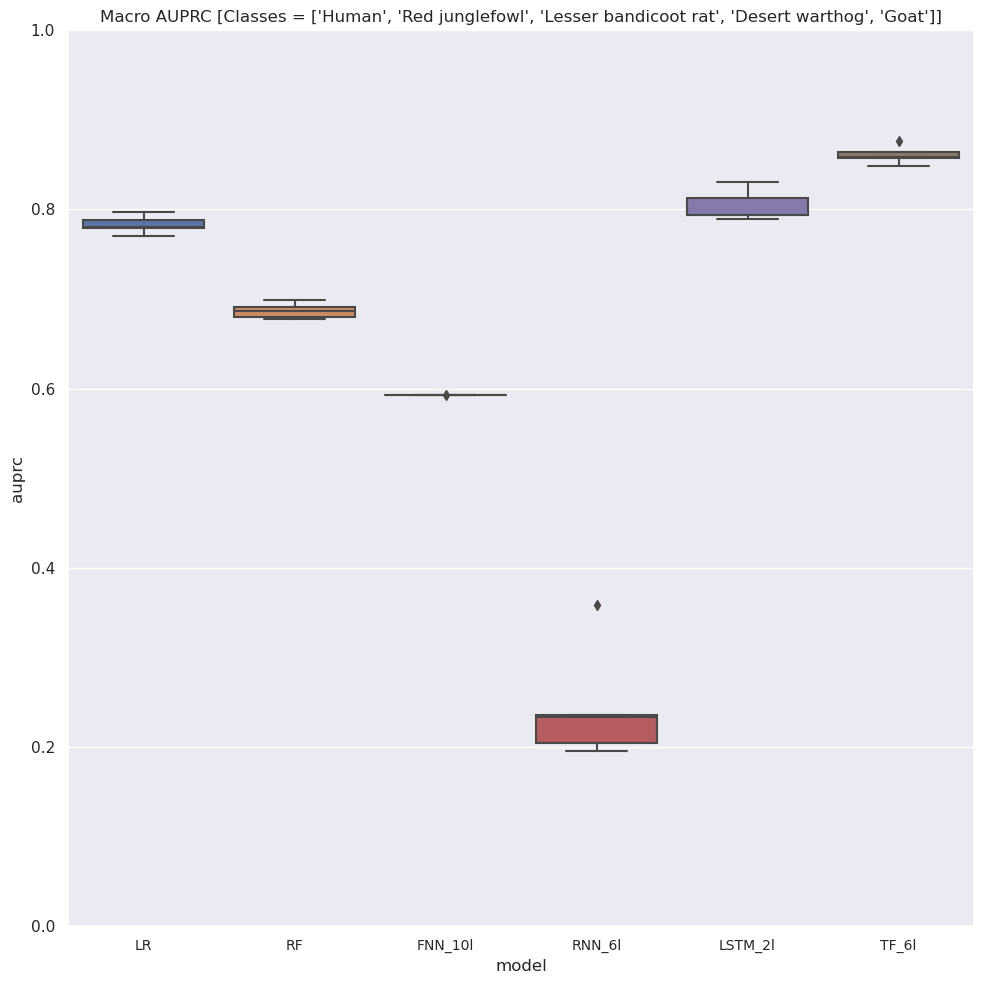

In [17]:
output_filepaths = {
    "LR": lr_output_filepath,
    "RF": rf_output_filepath,
    "FNN_10l": fnn_output_filepath,
    "RNN_6l": rnn_output_filepath,
    "LSTM_2l": lstm_output_filepath,
    "TF_6l": tf_output_filepath,
}
classes = ["Human", "Red junglefowl", "Lesser bandicoot rat", "Desert warthog", "Goat"]
auprc_analysis_classes_subset(output_filepaths, classes)